In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.colors import LogNorm


In [2]:
params={     
    'axes.labelsize'  : '14',   
    'axes.titlesize'  : '14',  
    'xtick.labelsize' :'14',
    'ytick.labelsize' :'14',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '10', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [8]:
## IMERG
satellite_path = "/g/data/k10/cb4968/metrics/observations/IMERG/small_domain/pr_based/IMERG/pr_based_IMERG_3hrly_0-360_-30-30_3600x1800_2001-01_2023-12_boxsize_5/"
sat_files = sorted(glob(f"{satellite_path}pr_based_IMERG_3hrly_*.nc"))
ds_sat = xr.open_mfdataset(sat_files,chunks={"time":10})
# ERA5
ds_tcwv = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/tcwv/*.nc")))
ds_max_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/max_cape/*.nc")))
ds_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/cape/*.nc")))
## land sea mask
ds_lsm = xr.open_dataset("/g/data/k10/cr7888/era5_daily_means_5deg/lsm_5deg.nc") 

In [7]:
lsm = ds_lsm["lsm"]
# max precipitation
max_pr = ds_sat["pr_based_max_pr_30min"].resample(time='1D').max().where(lsm == 0)
# mean precipitation
mean_pr = ds_sat["pr_based_mean_pr"].resample(time='1D').mean().where(lsm == 0)
# Iorg
iorg= ds_sat["pr_based_Iorg"].resample(time='1D').mean().where(lsm == 0)


In [9]:
%%time
## IMERG daily to match ERA5 timestamps
ds_tcwv["time"] = ds_tcwv["time"].dt.floor("D")
mean_pr_match = mean_pr.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
iorg_match = iorg.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
max_pr_match = max_pr.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()     

CPU times: user 1min 47s, sys: 14.5 s, total: 2min 1s
Wall time: 1min 39s


In [15]:
mean_pr_1D = mean_pr_match.values.flatten()
iorg_1D = iorg_match.values.flatten()
max_pr_1D = max_pr_match.values.flatten()

In [40]:
def compute_2d_hist(x, y, xmin=0, xmax=7, ymin=None, ymax=None, nbins=50, counts_thresh=10):
    if ymin==None and ymax==None:
        ymin, ymax = np.nanmin(y), np.nanmax(y)
    # 1) compute the raw 2D histogram
    counts, xedges, yedges = np.histogram2d(
        x, y,
        bins=nbins,
        range=[[xmin,xmax], [ymin, ymax]]
    )
    
    # 2) mask out bins with ≤ 10 samples
    counts_masked = np.where(counts > 1, counts, np.nan)
    
    # 3) build the mesh to plot
    X, Y = np.meshgrid(xedges, yedges)
    return X, Y, counts_masked.T

In [41]:
X1, Y1, mean_max_hist = compute_2d_hist(mean_pr_1D, max_pr_1D, nbins=60, counts_thresh=10)
X2, Y2, mean_iorg_hist = compute_2d_hist(mean_pr_1D, iorg_1D, nbins=60, counts_thresh=10)

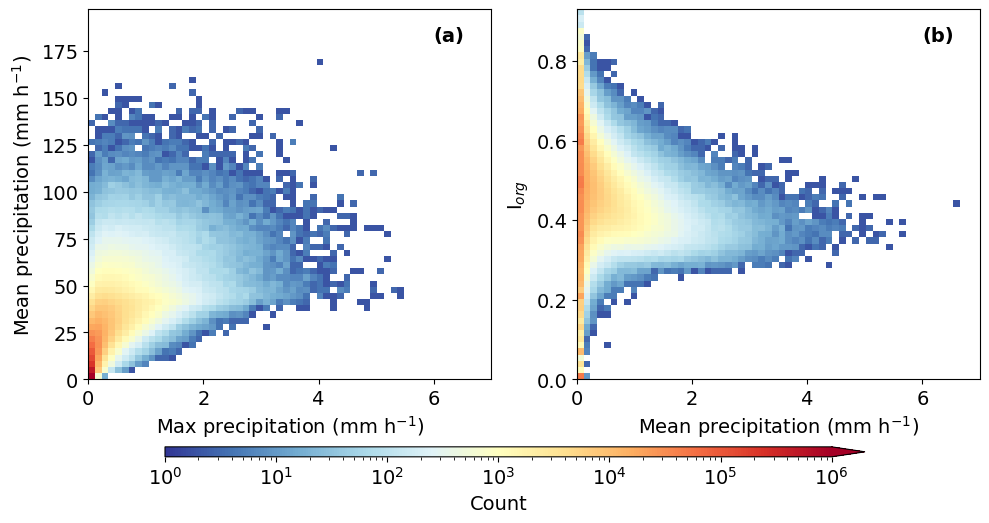

In [58]:

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
pcm1 = plt.pcolormesh(
    X1, Y1, mean_max_hist,       # note the transpose
    norm=LogNorm(vmin=1, vmax=10**6),
    cmap='RdYlBu_r',
    shading='auto'
)
# plt.colorbar(pcm, label="Count",extend ="max")
plt.xlabel("Max precipitation (mm h$^{-1}$)")
plt.ylabel("Mean precipitation (mm h$^{-1}$)")
ax1.set_xlim([0,7])
ax1.text(6,180, "(a)",fontsize=14, fontweight="bold") # x, y, s

ax2 = fig.add_subplot(122)
pcm2 = plt.pcolormesh(
    X2, Y2, mean_iorg_hist,       # note the transpose
    norm=LogNorm(vmin=1, vmax=10**6),
    cmap='RdYlBu_r',
    shading='auto'
)
# plt.colorbar(pcm, label="Count",extend ="max")
plt.xlabel("Mean precipitation (mm h$^{-1}$)")
plt.ylabel("I$_{org}$")
ax2.set_xlim([0,7])
ax2.text(6,0.85, "(b)",fontsize=14, fontweight="bold") # x, y, s

plt.tight_layout()
## add colorbar
fig.subplots_adjust(bottom = 0.23)

cbar_ax = fig.add_axes([0.17, 0.075, 0.7, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(pcm1,  cax = cbar_ax, orientation = "horizontal",extend ="max")#,ticks=[-1,1])
cbar.ax.set_xlabel("Count")
plt.savefig("/home/565/dl6968/meso-org/Figures/Fig5.png", dpi=200, bbox_inches="tight")

plt.show()